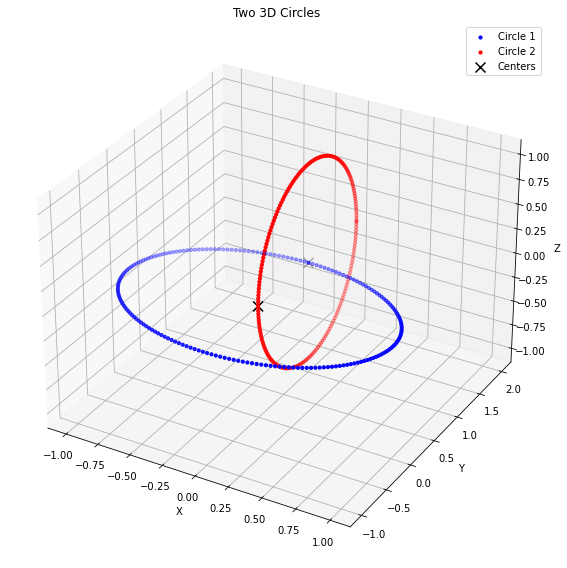

In [23]:
# 2 Circles Dataset 
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from model import EnergyBasedModel as EBM

import matplotlib.pyplot as plt

def generate_3d_circle_data(center, radius, normal_vector, num_points=100):
    """
    Generate points on a 3D circle with given center, radius, and normal vector.
    
    Parameters:
    - center: 3D coordinates of circle center
    - radius: radius of the circle
    - normal_vector: normal vector to the circle plane
    - num_points: number of points to generate
    
    Returns:
    - points on the circle
    """
    # Normalize the normal vector
    normal = np.array(normal_vector)
    normal = normal / np.linalg.norm(normal)
    
    # Find two orthogonal vectors in the circle plane
    if np.allclose(normal, [1, 0, 0]):
        v1 = np.array([0, 1, 0])
    else:
        v1 = np.cross(normal, [1, 0, 0])
        v1 = v1 / np.linalg.norm(v1)
    
    v2 = np.cross(normal, v1)
    v2 = v2 / np.linalg.norm(v2)
    
    # Generate circle points
    theta = np.linspace(0, 2 * np.pi, num_points)
    circle_points = center + radius * (np.outer(np.cos(theta), v1) + np.outer(np.sin(theta), v2))
    
    return circle_points

# Create the dataset
def create_circles_dataset(num_points=100):
    # Circle 1: centered at the origin, on the xy-plane
    center1 = np.array([0, 0, 0])
    radius1 = 1.0
    normal1 = np.array([0, 0, 1])  # Normal to xy-plane
    
    # Circle 2: centered at (0, 1, 0), on the yz-plane (perpendicular to Circle 1)
    center2 = np.array([0, 1, 0])
    radius2 = 1.0
    normal2 = np.array([1, 0, 0])  # Normal to yz-plane
    
    # Generate points
    circle1_points = generate_3d_circle_data(center1, radius1, normal1, num_points)
    circle2_points = generate_3d_circle_data(center2, radius2, normal2, num_points)
    
    # Combine into a dataset with labels
    X = np.vstack([circle1_points, circle2_points])
    y = np.array([0] * num_points + [1] * num_points)
    
    return X, y

# Generate the dataset
X, y = create_circles_dataset(num_points=200)

# Visualize
def visualize_circles(X, y):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot points for each circle
    colors = ['blue', 'red']
    for i, color in enumerate(colors):
        mask = (y == i)
        ax.scatter(X[mask, 0], X[mask, 1], X[mask, 2], c=color, s=10, label=f'Circle {i+1}')
    
    # Add circle centers
    centers = [np.array([0, 0, 0]), np.array([0, 1, 0])]
    ax.scatter([c[0] for c in centers], [c[1] for c in centers], [c[2] for c in centers], 
               c='black', s=100, marker='x', label='Centers')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Two 3D Circles')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Visualize the dataset
visualize_circles(X, y)

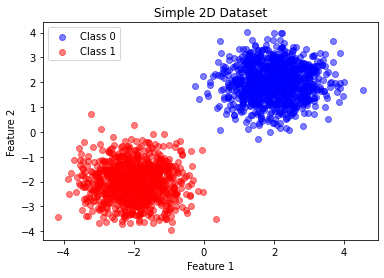

In [24]:
# Generate a simple 2D linearly separable dataset
num_points = 1000  # Number of points per class
class_0 = np.random.multivariate_normal(mean=[2, 2], cov=[[0.5, 0], [0, 0.5]], size=num_points)
class_1 = np.random.multivariate_normal(mean=[-2, -2], cov=[[0.5, 0], [0, 0.5]], size=num_points)

# Combine the data
X_simple = np.vstack((class_0, class_1))
y_simple = np.array([0] * num_points + [1] * num_points)

# Visualize the dataset
plt.scatter(X_simple[y_simple == 0, 0], X_simple[y_simple == 0, 1], color='blue', label='Class 0', alpha=0.5)
plt.scatter(X_simple[y_simple == 1, 0], X_simple[y_simple == 1, 1], color='red', label='Class 1', alpha=0.5)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simple 2D Dataset')
plt.legend()
plt.show()

X, y = X_simple, y_simple

In [25]:
# XOR Dataset 
X_xor = np.array([[0], [1], [1], [0]])
y_xor = np.array([0, 1, 1, 0])  # XOR labels

# # Increase the number of points
# X_xor = np.vstack([X_xor] * 250)  # Repeat the points to increase the dataset size
# y_xor = np.tile(y_xor, 250)  # Repeat the labels

# # Plot the XOR dataset
# plt.scatter(X_xor[y_xor == 0, 0], X_xor[y_xor == 0, 1], color='blue', label='Class 0', alpha=0.5)
# plt.scatter(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1], color='red', label='Class 1', alpha=0.5)
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.title('XOR Dataset')
# plt.legend()
# plt.show()

X, y = X_xor, y_xor 

In [26]:
# MNIST Dataset
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
y = y.astype(np.int32)  # Convert labels to integers
# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

In [27]:
# Now you can use this dataset (X, y) for training your model.
# Test, train split 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
import torch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create a DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=6, shuffle=False)

# Define the model 
model_config = {
    'input_size': 784,  # 3D input
    'hidden_sizes': [128, 10],  # Hidden layer sizes
    'beta': 0.2,  # Temperature parameter
    'dt': 0.05,   # Step size
    'n_steps': 20 # Number of steps
}

model = EBM(
    input_size=model_config['input_size'],
    hidden_sizes=model_config['hidden_sizes'],# Number of stepshidden_sizes'],
    beta=model_config['beta'],
    dt=model_config['dt'],
    optimizer=None,  # Optimizer will be set separately
    n_steps=model_config['n_steps']
)

# Define the optimizer
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Set the optimizer in the model
model.optimizer = optimizer
# Training loop
num_epochs = 3
model.debug = False
for epoch in range(num_epochs):
    model.train()
    targets = []
    preds = []
    for batch_X, batch_y in train_loader:
        # optimizer.zero_grad()
        output = model(batch_X,batch_y)
        preds.append(output)
        targets.append(batch_y)
    accuracy = (torch.cat(preds).argmax(dim=1) == torch.cat(targets)).float().mean()
    print(f"Epoch {epoch+1}/{num_epochs}, Accuracy: {accuracy.item():.4f}")

model.eval()
preds = []
targets = []
for batch_X, batch_y in test_loader:
    with torch.no_grad():
        output = model(batch_X)
        preds.append(output)
        targets.append(batch_y)
accuracy = (torch.cat(preds).argmax(dim=1) == torch.cat(targets)).float().mean()
print(f"Test Accuracy: {accuracy.item():.4f}")


Epoch 1/3, Accuracy: 0.9999
Epoch 2/3, Accuracy: 0.9999
Epoch 3/3, Accuracy: 0.9998
Test Accuracy: 0.1041


In [28]:
(torch.cat(preds).argmax(dim=1) == torch.cat(targets)).float().mean()

tensor(0.1041)

In [29]:
torch.cat(targets)

tensor([8, 4, 8,  ..., 2, 7, 1])

In [30]:
torch.cat(preds).argmax(dim=1)

tensor([4, 4, 2,  ..., 1, 8, 2])

In [31]:
targets

[tensor([8, 4, 8, 7, 7, 0]),
 tensor([6, 2, 7, 4, 3, 9]),
 tensor([9, 8, 2, 5, 9, 1]),
 tensor([7, 8, 0, 0, 0, 3]),
 tensor([6, 3, 6, 1, 6, 9]),
 tensor([7, 6, 0, 8, 5, 5]),
 tensor([2, 9, 1, 6, 4, 9]),
 tensor([7, 7, 4, 5, 2, 7]),
 tensor([3, 9, 2, 0, 6, 8]),
 tensor([5, 3, 1, 4, 0, 9]),
 tensor([1, 7, 5, 3, 9, 5]),
 tensor([7, 9, 6, 0, 1, 7]),
 tensor([3, 0, 4, 3, 4, 3]),
 tensor([5, 6, 6, 6, 8, 2]),
 tensor([7, 1, 1, 3, 8, 8]),
 tensor([7, 5, 1, 8, 2, 0]),
 tensor([8, 7, 3, 0, 3, 4]),
 tensor([0, 4, 4, 5, 1, 3]),
 tensor([5, 0, 8, 3, 7, 1]),
 tensor([9, 9, 1, 3, 9, 1]),
 tensor([5, 7, 8, 4, 8, 1]),
 tensor([2, 0, 9, 9, 1, 6]),
 tensor([3, 9, 3, 5, 6, 3]),
 tensor([1, 1, 3, 4, 2, 1]),
 tensor([4, 3, 5, 6, 2, 8]),
 tensor([2, 1, 8, 7, 0, 6]),
 tensor([4, 7, 7, 0, 8, 1]),
 tensor([5, 5, 2, 3, 5, 0]),
 tensor([0, 8, 0, 9, 1, 0]),
 tensor([7, 6, 4, 2, 2, 8]),
 tensor([2, 5, 7, 3, 6, 6]),
 tensor([2, 1, 2, 3, 9, 1]),
 tensor([7, 9, 8, 6, 5, 3]),
 tensor([5, 9, 1, 5, 9, 3]),
 tensor([8, 2,

In [32]:
batch_y

tensor([7, 1])

In [33]:
model.states[-1]

tensor([[0.1535, 0.3846, 0.1015, 0.1460, 0.2968, 0.2040, 0.1518, 0.0250, 0.3905,
         0.1360],
        [0.2732, 0.2699, 0.4612, 0.2290, 0.0075, 0.1173, 0.0885, 0.4208, 0.3709,
         0.2325]])

In [ ]:
import torch
# import torch.nn.functional as F # Not strictly needed here, but often useful
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import time
import os
import numpy as np # Still needed for some initial setup/indexing

# --- Device Setup ---
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available(): # Optional: Add CUDA check
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# --- PyTorch Activation Functions ---
def hard_sigmoid_pt(s):
    # Use torch.clamp for PyTorch tensors
    return torch.clamp(s, 0, 1)

def hard_sigmoid_deriv_pt(s):
    # Boolean tensor operations in PyTorch
    return ((s >= 0) & (s <= 1)).float() # Ensure float output

# --- PyTorch BATCHED Energy Gradient Calculation ---
def get_total_energy_grad_batched_pt(s_batch, W, b_full, beta, target_y_batch,
                                     input_units_indices_pt, state_units_indices_pt,
                                     s_output_units_pt, rho_u_batch, rho_prime_s_batch):
    """
    Calculates dF/ds for a BATCH of states using PyTorch.
    Shapes:
        s_batch: (B, num_state_units)
        W: (total_dim, total_dim)
        b_full: (total_dim,)
        target_y_batch: (B, output_dim) or None
        rho_u_batch: (B, total_dim)
        rho_prime_s_batch: (B, num_state_units)
    Returns:
        grad_F_batch: (B, num_state_units)
    """
    # Matmul in PyTorch is '@'
    full_sum_term_batch = rho_u_batch @ W + b_full # Broadcasting works

    # Indexing in PyTorch
    sum_term_s_batch = full_sum_term_batch[:, state_units_indices_pt]

    grad_E_batch = s_batch - rho_prime_s_batch * sum_term_s_batch

    grad_C_batch = torch.zeros_like(s_batch)
    if beta > 0 and target_y_batch is not None:
        # Ensure target_y_batch is on the correct device
        target_y_batch = target_y_batch.to(s_batch.device)
        if target_y_batch.shape[1] != len(s_output_units_pt):
             raise ValueError(f"Shape mismatch: target_y shape {target_y_batch.shape} vs number of output units in s {len(s_output_units_pt)}")
        # Indexing output units within the batch
        grad_C_batch[:, s_output_units_pt] = s_batch[:, s_output_units_pt] - target_y_batch

    grad_F_batch = grad_E_batch + beta * grad_C_batch
    return grad_F_batch

# --- PyTorch BATCHED Dynamics Simulation ---
def run_dynamics_batched_pt(s_init_batch, u_input_batch, W, b, beta, target_y_batch, n_iter, dt,
                            input_dim, hidden_units_pt, output_units_pt, # Pass torch indices
                            input_units_indices_pt, state_units_indices_pt, s_output_units_pt):
    """
    Simulates network dynamics for a BATCH using PyTorch.
    """
    B = s_init_batch.shape[0]
    total_dim = W.shape[0]
    s_batch = s_init_batch.clone() # Use clone for PyTorch tensors
    u_batch = torch.zeros(B, total_dim, device=s_batch.device)
    u_batch[:, :input_dim] = u_input_batch # Clamp inputs

    for _ in range(n_iter):
        u_batch[:, state_units_indices_pt] = s_batch # Update non-clamped part
        rho_u_batch = hard_sigmoid_pt(u_batch)
        rho_prime_s_batch = hard_sigmoid_deriv_pt(s_batch)

        grad_F_s_batch = get_total_energy_grad_batched_pt(s_batch, W, b, beta, target_y_batch,
                                                          input_units_indices_pt, state_units_indices_pt,
                                                          s_output_units_pt, rho_u_batch, rho_prime_s_batch)
        # Update state s for the batch
        s_batch = torch.clamp(s_batch - dt * grad_F_s_batch, 0, 1)

    return s_batch

# --- Data Preparation ---
print("Loading MNIST dataset...")
mnist_data_home = './mnist_cache'
os.makedirs(mnist_data_home, exist_ok=True)
mnist = fetch_openml('mnist_784', version=1, data_home=mnist_data_home, parser='auto')
print("MNIST loaded.")
# Load as numpy first
X_pd = mnist.data.astype('float32') / 255.0 # Keep as pandas initially
y_np = mnist.target.astype('int')
num_classes = 10
y_one_hot_np = np.eye(num_classes)[y_np].astype('float32')

# Split pandas DataFrames
X_train_pd, X_test_pd = X_pd[:60000], X_pd[60000:]
# Split numpy arrays for one-hot labels
y_train_np, y_test_np = y_one_hot_np[:60000], y_one_hot_np[60000:]
# Split the original integer labels (which might be Series)
y_train_labels_pd, y_test_labels_pd = y_np[:60000], y_np[60000:] # Keep temp names

print("Converting data slices to NumPy arrays...")
X_train_np = X_train_pd.to_numpy()
X_test_np = X_test_pd.to_numpy()
# Convert label Series to NumPy arrays <<< FIX HERE
y_train_labels_np = y_train_labels_pd.to_numpy()
y_test_labels_np = y_test_labels_pd.to_numpy()
print("Conversion complete.")

# --- Ensure float32 dtype ---
print("Ensuring float32 dtype for NumPy arrays...")
X_train_np = X_train_np.astype(np.float32)
X_test_np = X_test_np.astype(np.float32)
# y_train_np and y_test_np were already explicitly float32

# Convert to PyTorch tensors and move to device
print(f"Moving data to device: {device}...")
X_train = torch.from_numpy(X_train_np).to(device)
y_train = torch.from_numpy(y_train_np).to(device)
X_test = torch.from_numpy(X_test_np).to(device)
y_test = torch.from_numpy(y_test_np).to(device)

# Keep test labels on CPU as numpy for final comparison
# Now y_test_labels_np is guaranteed to be a NumPy array
y_test_labels = torch.from_numpy(y_test_labels_np).long()
print("Data moved.")
# --- Network Parameters ---
input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = y_train.shape[1]
total_dim = input_dim + hidden_dim + output_dim
num_state_units = hidden_dim + output_dim
num_layers = 10
print(f"Network Dimensions: Input={input_dim}, Hidden={hidden_dim}, Output={output_dim}")

# --- Define unit indices (NumPy for setup, then convert to Torch tensors for indexing) ---
input_units_np = np.arange(input_dim)
hidden_units_np = np.arange(input_dim, input_dim + hidden_dim)
output_units_np = np.arange(input_dim + hidden_dim, total_dim)
state_units_np = np.arange(input_dim, total_dim)

# Convert indices to PyTorch tensors (long type for indexing) on the correct device
input_units_indices_pt = torch.from_numpy(input_units_np).long().to(device)
hidden_units_pt = torch.from_numpy(hidden_units_np).long().to(device)
output_units_pt = torch.from_numpy(output_units_np).long().to(device)
state_units_indices_pt = torch.from_numpy(state_units_np).long().to(device)

# Indices relative to s vector (for applying grad_C) - calculated once
s_output_units_mask_np = np.isin(state_units_np, output_units_np)
s_output_units_np = np.where(s_output_units_mask_np)[0]
s_output_units_pt = torch.from_numpy(s_output_units_np).long().to(device)


# --- Initialization (PyTorch Tensors) ---
def glorot_uniform_pt(dim_in, dim_out, device):
    limit = np.sqrt(6 / (dim_in + dim_out))
    # Use torch.rand and uniform_
    tensor = torch.empty((dim_in, dim_out), device=device)
    tensor.uniform_(-limit, limit)
    return tensor

# Initialize weights directly on the device
W_ih = glorot_uniform_pt(input_dim, hidden_dim, device=device)
W_ho = glorot_uniform_pt(hidden_dim, output_dim, device=device)

# Weight Matrix (Symmetric, requires_grad=False by default)
W = torch.zeros((total_dim, total_dim), device=device)
# Use PyTorch slicing/indexing
W[input_units_indices_pt[:, None], hidden_units_pt] = W_ih # Advanced indexing requires care
W[hidden_units_pt[:, None], input_units_indices_pt] = W_ih.T
W[hidden_units_pt[:, None], output_units_pt] = W_ho
W[output_units_pt[:, None], hidden_units_pt] = W_ho.T

# Biases (on device)
b = torch.zeros(total_dim, device=device)

# --- Training Parameters ---
epochs = 500
batch_size = 1024 # ADJUSTABLE: Can often be larger with GPU
subset_size_per_epoch = 10000 # ADJUSTABLE: Process 10k samples/epoch

# Learning rates might need adjustment
lr_ih = 0.02
lr_ho = 0.005
lr_b = 0.01
beta = 0.5
dt = 0.2
# Iteration counts - still critical
n_iter_free = 50
n_iter_nudge = 10

print(f"Batch Size: {batch_size}")
print(f"Subset Size per Epoch: {subset_size_per_epoch}")
print(f"Using dt={dt}, n_iter_free={n_iter_free}, n_iter_nudge={n_iter_nudge} (N={num_layers})")
print(f"Learning Rates: W_ih={lr_ih}, W_ho={lr_ho}, biases={lr_b}")

# --- Training Loop with SUBSET and BATCHING (PyTorch) ---
print(f"Starting PyTorch training (Subset={subset_size_per_epoch})...")
start_time = time.time()
train_losses = []
test_accuracies = []

num_samples_train = X_train.shape[0]
# Calculate num_batches based on the subset size
if subset_size_per_epoch > num_samples_train:
    subset_size_per_epoch = num_samples_train
    print(f"Warning: subset_size_per_epoch > training samples. Using full dataset ({num_samples_train}) per epoch.")
num_batches = subset_size_per_epoch // batch_size

if num_batches == 0:
     raise ValueError("batch_size is larger than subset_size_per_epoch. Decrease batch_size or increase subset_size_per_epoch.")

for epoch in range(epochs):
    # Accumulators for gradients (PyTorch tensors on device)
    dW_ih_epoch = torch.zeros_like(W_ih)
    dW_ho_epoch = torch.zeros_like(W_ho)
    db_h_epoch = torch.zeros(hidden_dim, device=device)
    db_y_epoch = torch.zeros(output_dim, device=device)
    total_epoch_loss = 0

    # --- Select random subset for the epoch ---
    epoch_indices = torch.randperm(num_samples_train, device=device)[:subset_size_per_epoch]

    for i in range(num_batches):
        # Get batch indices from the epoch subset
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        batch_indices_in_epoch = epoch_indices[start_idx:end_idx]

        # Get batch data using indices
        x_batch = X_train[batch_indices_in_epoch]
        y_target_batch = y_train[batch_indices_in_epoch]

        # Initialize state s for the batch (on device)
        s_initial_batch = torch.rand(batch_size, num_state_units, device=device) * 0.1

        # --- Phase 1: Free Phase (PyTorch Batched) ---
        s_free_batch = run_dynamics_batched_pt(s_initial_batch, x_batch, W, b, 0, None, n_iter_free, dt,
                                               input_dim, hidden_units_pt, output_units_pt,
                                               input_units_indices_pt, state_units_indices_pt, s_output_units_pt)
        # Store full state activation rho(u^0)
        u_free_batch = torch.cat((x_batch, s_free_batch), dim=1) # Concatenate along feature dim
        rho_u_free_batch = hard_sigmoid_pt(u_free_batch)

        # --- Phase 2: Weakly Clamped Phase (PyTorch Batched) ---
        s_nudge_batch = run_dynamics_batched_pt(s_free_batch, x_batch, W, b, beta, y_target_batch, n_iter_nudge, dt,
                                                input_dim, hidden_units_pt, output_units_pt,
                                                input_units_indices_pt, state_units_indices_pt, s_output_units_pt)
        # Store full state activation rho(u^beta)
        u_nudge_batch = torch.cat((x_batch, s_nudge_batch), dim=1)
        rho_u_nudge_batch = hard_sigmoid_pt(u_nudge_batch)

        # --- Calculate Parameter Updates for the Batch (PyTorch) ---
        # Contrastive term for weights (averaged over batch)
        # Use torch.einsum and torch.mean
        contrast_W_batch_avg = (torch.mean(torch.einsum('bi,bj->bij', rho_u_nudge_batch, rho_u_nudge_batch), dim=0) -
                                torch.mean(torch.einsum('bi,bj->bij', rho_u_free_batch, rho_u_free_batch), dim=0))
        dW_total_batch_avg = (1.0 / beta) * contrast_W_batch_avg

        # Accumulate layer-specific weight gradients
        # Use PyTorch advanced indexing (might need .contiguous() if views cause issues, but try without first)
        dW_ih_epoch += dW_total_batch_avg[input_units_indices_pt[:, None], hidden_units_pt]
        dW_ho_epoch += dW_total_batch_avg[hidden_units_pt[:, None], output_units_pt]


        # Contrastive term for biases (averaged over batch)
        contrast_b_batch_avg = torch.mean(rho_u_nudge_batch - rho_u_free_batch, dim=0)
        db_total_batch_avg = (1.0 / beta) * contrast_b_batch_avg

        # Accumulate bias gradients
        db_h_epoch += db_total_batch_avg[hidden_units_pt]
        db_y_epoch += db_total_batch_avg[output_units_pt]

        # Calculate loss J = 0.5 * || y_target - y^0 ||^2 (averaged over batch)
        y_free_batch = s_free_batch[:, s_output_units_pt] # Extract output units
        loss_batch = 0.5 * torch.sum((y_target_batch - y_free_batch)**2, dim=1) # Sum over outputs
        avg_loss_batch = torch.mean(loss_batch) # Average over batch
        # Use .item() to get Python number for accumulation if needed, but can sum tensors
        total_epoch_loss += avg_loss_batch.item() * batch_size # Accumulate total loss based on Python float


    # --- Update Weights and Biases (end of epoch) ---
    # Gradients accumulated are sums of batch averages, divide by num_batches processed
    # Perform updates in place
    delta_W_ih = lr_ih * (dW_ih_epoch / num_batches)
    W[input_units_indices_pt[:, None], hidden_units_pt] += delta_W_ih
    W[hidden_units_pt[:, None], input_units_indices_pt] += delta_W_ih.T # Maintain symmetry

    delta_W_ho = lr_ho * (dW_ho_epoch / num_batches)
    W[hidden_units_pt[:, None], output_units_pt] += delta_W_ho
    W[output_units_pt[:, None], hidden_units_pt] += delta_W_ho.T # Maintain symmetry

    delta_b_h = lr_b * (db_h_epoch / num_batches)
    b[hidden_units_pt] += delta_b_h
    delta_b_y = lr_b * (db_y_epoch / num_batches)
    b[output_units_pt] += delta_b_y

    # Average loss over the number of samples processed in the epoch
    avg_epoch_loss = total_epoch_loss / subset_size_per_epoch
    train_losses.append(avg_epoch_loss)
    print(f"\nEpoch {epoch+1}/{epochs}, Avg Loss: {avg_epoch_loss:.7f}", end='')

    # --- Evaluation during training (BATCHED PyTorch) ---
    # Wrap evaluation in torch.no_grad()
    with torch.no_grad():
        predictions = []
        num_samples_test = X_test.shape[0]
        # Use a potentially different batch size for evaluation if memory is tight
        eval_batch_size = 512
        num_batches_test = (num_samples_test + eval_batch_size - 1) // eval_batch_size # Ceiling division

        for i_eval in range(num_batches_test):
            start_idx = i_eval * eval_batch_size
            end_idx = min(start_idx + eval_batch_size, num_samples_test)
            x_eval_batch = X_test[start_idx:end_idx]
            current_eval_batch_size = x_eval_batch.shape[0]

            s_init_eval_batch = torch.rand(current_eval_batch_size, num_state_units, device=device) * 0.1
            # Run free dynamics for prediction (Batched PyTorch)
            s_pred_free_batch = run_dynamics_batched_pt(s_init_eval_batch, x_eval_batch, W, b, 0, None, n_iter_free, dt,
                                                        input_dim, hidden_units_pt, output_units_pt,
                                                        input_units_indices_pt, state_units_indices_pt, s_output_units_pt)
            # Get predictions for the batch
            batch_predictions = torch.argmax(s_pred_free_batch[:, s_output_units_pt], dim=1) # Argmax over output units
            predictions.append(batch_predictions) # Keep as tensor list

        # Concatenate predictions and move to CPU for comparison with numpy labels if needed
        all_predictions = torch.cat(predictions).cpu().numpy()
        # Ensure test labels are on CPU for comparison
        accuracy = np.mean(all_predictions == y_test_labels_np[:len(all_predictions)]) # Compare with true labels (numpy)

    test_accuracies.append(accuracy)
    print(f", Test Acc: {accuracy:.4f}")


end_time = time.time()
print(f"\nTraining finished in {end_time - start_time:.2f} seconds.")

# --- Final Evaluation (BATCHED PyTorch) ---
print("\nRunning final evaluation on test set (Batched PyTorch)...")
with torch.no_grad():
    predictions = []
    num_samples_test = X_test.shape[0]
    eval_batch_size = 512
    num_batches_test = (num_samples_test + eval_batch_size - 1) // eval_batch_size # Ceiling division

    for i in range(num_batches_test):
        start_idx = i * eval_batch_size
        end_idx = min(start_idx + eval_batch_size, num_samples_test)
        x_batch = X_test[start_idx:end_idx]
        current_batch_size = x_batch.shape[0]

        s_init = torch.rand(current_batch_size, num_state_units, device=device) * 0.1
        s_pred_free = run_dynamics_batched_pt(s_init, x_batch, W, b, 0, None, n_iter_free, dt,
                                              input_dim, hidden_units_pt, output_units_pt,
                                              input_units_indices_pt, state_units_indices_pt, s_output_units_pt)
        batch_predictions = torch.argmax(s_pred_free[:, s_output_units_pt], dim=1)
        predictions.append(batch_predictions)

    all_predictions = torch.cat(predictions).cpu().numpy()
    accuracy = np.mean(all_predictions == y_test_labels_np) # Use full numpy test labels

print(f"Final Test Accuracy: {accuracy:.4f}")

# --- Plotting (Convert tensors back to numpy if needed, but matplotlib handles lists) ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Average Training Loss (Subset)')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.ylim(bottom=0)
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), test_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy over Epochs')
plt.grid(True)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()


Using device: cpu
Loading MNIST dataset...
MNIST loaded.
Converting data slices to NumPy arrays...
Conversion complete.
Ensuring float32 dtype for NumPy arrays...
Moving data to device: cpu...
Data moved.
Network Dimensions: Input=784, Hidden=128, Output=10
Batch Size: 1024
Subset Size per Epoch: 10000
Using dt=0.2, n_iter_free=50, n_iter_nudge=10 (N=10)
Learning Rates: W_ih=0.02, W_ho=0.005, biases=0.01
Starting PyTorch training (Subset=10000)...

Epoch 1/500, Avg Loss: 2.8048533, Test Acc: 0.0618
